# Goal of Analysis:

### Analyze the internal data about employees and see whether results suggest that the company is treating its employees fairly regarding the diversity situation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
company = pd.read_csv('company_hierarchy.csv')
company.head()

,employee_id,boss_id,dept
0,46456,175361.0,sales
1,104708,29733.0,HR
2,120853,41991.0,sales
3,142630,171266.0,HR
4,72711,198240.0,sales


In [3]:
employee = pd.read_csv('employee.csv')
employee.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
0,138719,0,273000.0,Master,M,2
1,3192,0,301000.0,Bachelor,F,1
2,114657,0,261000.0,Master,F,2
3,29039,0,86000.0,High_School,F,4
4,118607,0,126000.0,Bachelor,F,3


In [4]:
company.shape, employee.shape

((10000, 3), (10000, 6))

### Part 1: Data Preprocess

In [5]:
combined = pd.merge(left = company, right = employee, on = 'employee_id')
combined.head()

,employee_id,boss_id,dept,signing_bonus,salary,degree_level,sex,yrs_experience
0,46456,175361.0,sales,0,213000.0,Bachelor,M,5
1,104708,29733.0,HR,0,79000.0,Bachelor,F,3
2,120853,41991.0,sales,0,199000.0,High_School,M,5
3,142630,171266.0,HR,0,143000.0,PhD,F,13
4,72711,198240.0,sales,0,235000.0,Master,M,1


In [6]:
combined.shape

(10000, 8)

### Part 2: Question 1:

In the company there are 6 levels (described below). Identify, for each employee, her corresponding level.

Individual Contributors (IC) - they don't manage anyone

Middle Managers (MM) - they are the direct bosses of IC

Directors (D) - they are the direct bosses of MM

VP - D direct bosses

Executives (E) - VP direct bosses

CEO - The direct boss of E.

In [7]:
# initialize
new = pd.read_csv("company_hierarchy.csv", index_col='employee_id')
new['level'] = None 

# starting point
new.loc[new.dept == 'CEO','level'] = 'CEO'

# change all boss_id to integer
new.loc[new.level == 'CEO','boss_id'] = -1
new['boss_id'] = new.boss_id.astype(int)

# function to count the value
def set_level(boss_level,level):
    boss_ids = new.loc[new.level == boss_level,:].index
    is_subordinate = np.in1d(new.boss_id,boss_ids)
    new.loc[is_subordinate,'level'] = level

set_level('CEO','E')
set_level('E','VP')
set_level('VP','D')
set_level('D','MM')
set_level('MM','IC')

In [8]:
# value counts for each group

new.level.value_counts()

IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: level, dtype: int64

### Part 3: Qustion 2:

How many people each employee manages? You should have a table with employee ids and the number of people managed. Consider that if John directly manages 2 people and these two people manage 5 people each, then we conclude that John manages 12 people.

In [9]:
# find the managed employees for each employee
levels = ['CEO', 'E', 'VP', 'D', 'MM', 'IC']
combined.loc[combined['dept'] == 'CEO', 'level'] = 'CEO'
combined['counts'] = 0

for level in ['IC', 'MM', 'D', 'VP', 'E']:
    boss_ids = combined[combined['level'] == level]['boss_id']
    employee_ids = combined[combined['level'] == level]['employee_id']
    for b_id, e_id in zip(boss_ids, employee_ids):
        e_counts = int(1 + combined.loc[data['employee_id'] == e_id, 'counts'])
        b_counts = int(combined.loc[combined['employee_id'] == b_id, 'counts'])
        combined.loc[combined['employee_id'] == b_id, 'counts'] = e_counts + b_counts

In [10]:
# take a sample to have a look at the table

combined[['employee_id', 'level', 'counts']].sample(10)

,employee_id,level,counts
7248,123666,NaN,0
4268,196953,NaN,0
9490,127788,NaN,0
7015,187173,NaN,0
4952,6222,NaN,0
9883,187192,NaN,0
7068,143877,NaN,0
6047,139498,NaN,0
8904,165467,NaN,0
1171,195798,NaN,0


### Part 4: Question 3:

Build a model to predict the salary of each employee.

I will try to build machine learning models with light GBM

In [11]:
# Drop CEO department
combined = combined[combined['dept'] != 'CEO']

# drop useless features
combined = combined.drop(labels=['employee_id', 'boss_id', 'level', 'counts'], axis=1)

combined.head()

,dept,signing_bonus,salary,degree_level,sex,yrs_experience
0,sales,0,213000.0,Bachelor,M,5
1,HR,0,79000.0,Bachelor,F,3
2,sales,0,199000.0,High_School,M,5
3,HR,0,143000.0,PhD,F,13
4,sales,0,235000.0,Master,M,1


In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb

# encoding categorical data
combined['sex'] = (combined['sex'] == 'M').astype(int)

degree_encoder = LabelEncoder()
combined['degree_level'] = degree_encoder.fit_transform(combined['degree_level'])

dept_encoder = LabelEncoder()
combined['dept'] = dept_encoder.fit_transform(combined['dept'])

In [13]:
# define categorical features

categorical_feature = ['signing_bonus', 'degree_level', 'sex', 'dept']
combined[categorical_feature] = combined[categorical_feature].astype('category')

In [14]:
# split into training and test data set
X = combined.drop('salary', axis=1)
y = combined['salary']

X_train, X_test, y_train, y_test \
    = train_test_split(X, y, test_size=0.25, random_state=42)

# transform into log scale
y_train = np.log(y_train)
y_test = np.log(y_test)

In [15]:
# create LightGBM dataset
d_train = lgb.Dataset(data=X_train, label=y_train, free_raw_data=False, 
                      categorical_feature=categorical_feature)

In [16]:
# Cross validation
params = {'learning_rate': 0.01, 
          'boosting_type': 'gbdt', 
          'objective': 'regression', 
          'metric': 'rmse', 
          'sub_feature':0.5, 
          'num_leaves': 31, 
          'min_data': 50, 
          'max_depth': 30}

history = lgb.cv(params, train_set=d_train, num_boost_round=1000, nfold=5, 
                 early_stopping_rounds=20, seed=42, stratified=False)

best_round = len(history['rmse-mean'])
print('Best rounds:\t', best_round)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [17]:
# re-train the model and make predictions

clf = lgb.train(params, train_set=d_train, num_boost_round=best_round)
pred = clf.predict(X_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44
[LightGBM] [Info] Number of data points in the train set: 7499, number of used features: 5
[LightGBM] [Info] Start training from score 12.025515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [18]:
print('Test RMSE:\t', np.sqrt(mean_squared_error(y_test, pred)))
print('Test R2:\t', r2_score(y_test, pred))

Test RMSE:	 0.3979680431547868
Test R2:	 0.4196336668014382


### Part 5: Question 4:

Describe the main factors impacting employee salaries. Do you think the company has been treating its employees fairly? Do you see any bias? What are the next steps you would suggest to the Head of HR?

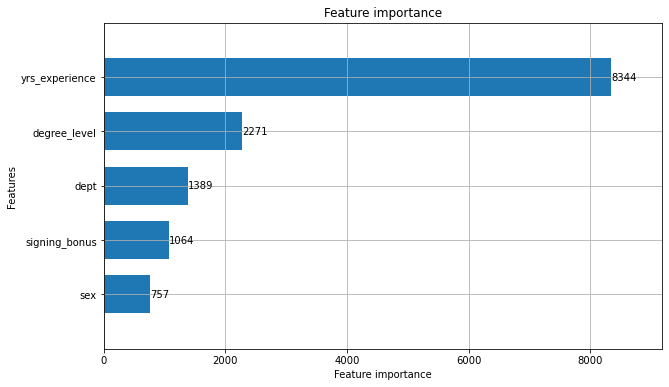

In [19]:
# feature importance

features = clf.feature_name()
importance = clf.feature_importance()

fig, ax = plt.subplots(figsize=(10, 6))
lgb.plot_importance(clf, ax=ax, height=0.7)
plt.show()

We can see that years of experience is the most important factor, following by degree level and department.